In [1]:
from pathlib import Path
from mapillary_sls.datasets.msls import MSLS
from mapillary_sls.datasets.generic_dataset import ImagesFromList
from mapillary_sls.utils.utils import configure_transform
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from mapillary_sls.utils.visualize import denormalize, visualize_triplets
from mapillary_sls.datasets import collate_tuples
from evaluate import download_msls_sample

# Download MSLS sample

In [2]:
SAMPLE_CITIES = "zurich"

root_dir = Path('../../data/MSLS_train_val/')

if not root_dir.exists():
    download_msls_sample(root_dir)


# Load dataset for testing


In [3]:
# get transform
meta = {'mean': [0.485, 0.456, 0.406], 'std': [0.229, 0.224, 0.225]}
transform = configure_transform(image_dim = (480, 640), meta = meta)

# positive are defined within a radius of 25 m
posDistThr = 25

# choose task to test on [im2im, seq2im, im2seq, seq2seq]
task = 'seq2seq'

# choose sequence length
seq_length = 3

# choose subtask to test on [all, s2w, w2s, o2n, n2o, d2n, n2d]
subtask = 'all'

val_dataset = MSLS(root_dir, cities = SAMPLE_CITIES, transform = transform, mode = 'test',
                   task = task, seq_length = seq_length, subtask = subtask, posDistThr = posDistThr)

opt = {'batch_size': 1}

# get images
qLoader = DataLoader(ImagesFromList(val_dataset.qImages[val_dataset.qIdx], transform), **opt)
dbLoader = DataLoader(ImagesFromList(val_dataset.dbImages, transform), **opt)

# get positive index (we allow some more slack: default 25 m)
pIdx = val_dataset.pIdx

=====> zurich


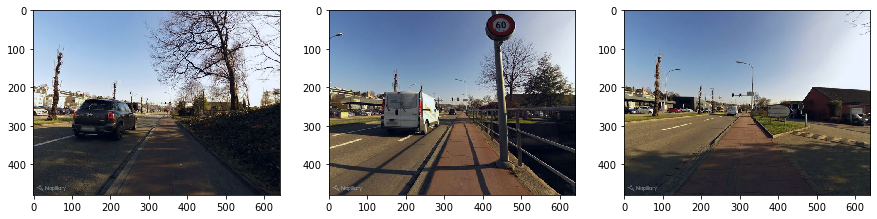

In [4]:
for batch in qLoader:
    x, y = batch

    plt.figure(figsize=(15,10))
    for i,im in enumerate(x):
        plt.subplot(1,seq_length, i+1)
        plt.imshow(denormalize(im[0].permute(1,2,0)))
    plt.show()
    break

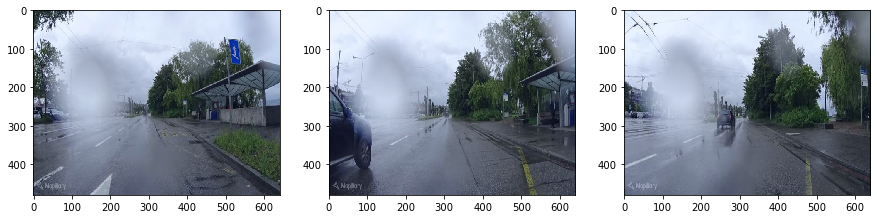

In [5]:
for batch in dbLoader:
    x, y = batch

    plt.figure(figsize=(15,10))
    for i,im in enumerate(x):
        plt.subplot(1,seq_length, i+1)
        plt.imshow(denormalize(im[0].permute(1,2,0)))
    plt.show() 
    break

# Load dataset for training (triplets)

In [6]:
posDistThr = 5

# negatives are defined outside a radius of 25 m
negDistThr = 25

# number of negatives per triplet
nNeg = 5

# number of cached queries
cached_queries = 1

# number of cached negatives
cached_negatives = 100

# whether to use positive sampling
positive_sampling = True

# choose the cities to load
cities = SAMPLE_CITIES

# choose task to test on [im2im, seq2im, im2seq, seq2seq]
task = 'seq2seq'

# choose sequence length
seq_length = 3

train_dataset = MSLS(root_dir, cities = cities, transform = transform, mode = 'train', task = task, seq_length = seq_length,
                    negDistThr = negDistThr, posDistThr = posDistThr, nNeg = nNeg, cached_queries = cached_queries,
                    cached_negatives = cached_negatives, positive_sampling = positive_sampling)


=====> zurich
#Sideways [0/895]; #Night; [0/895]
Forward and Day weighted with 1.0000


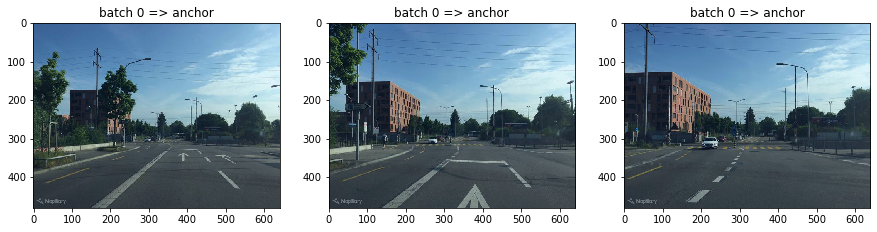

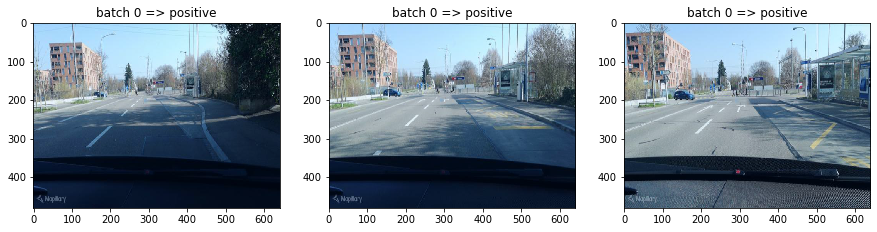

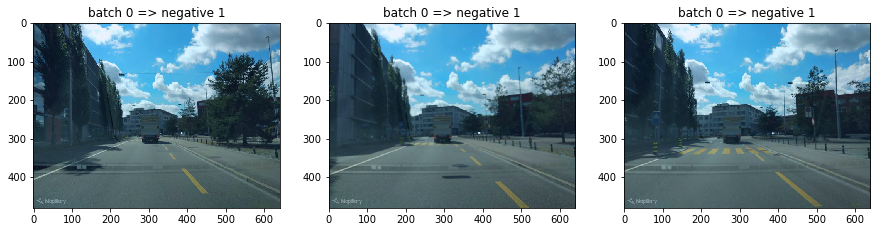

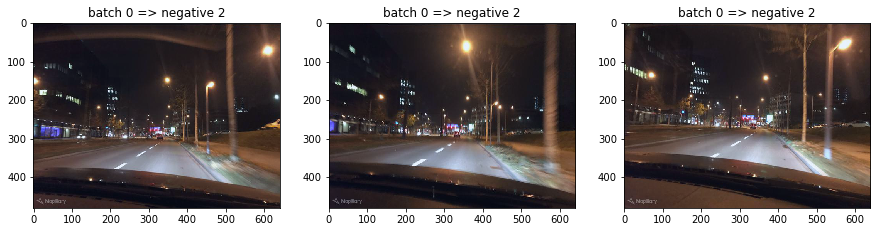

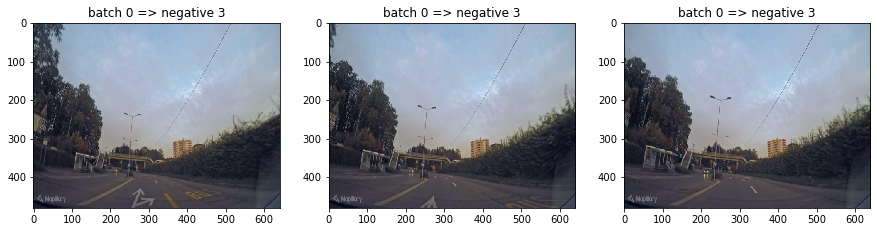

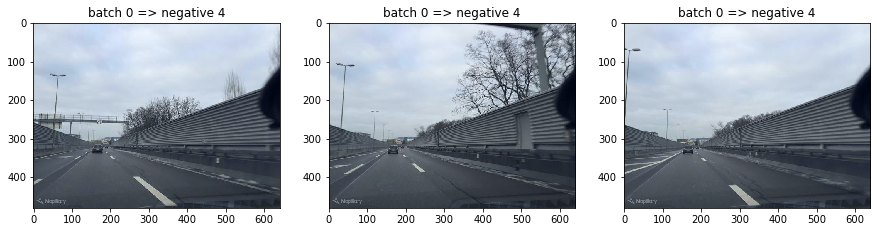

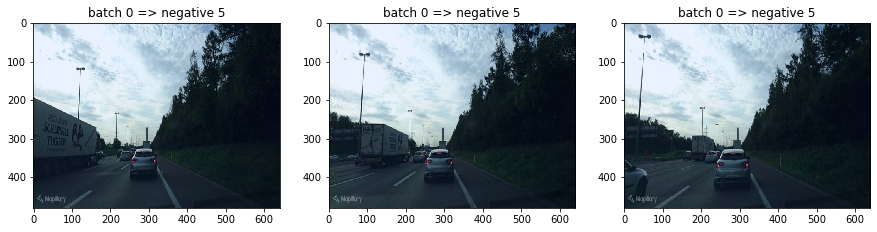

In [9]:
# devices dataset into smaller cache sets
train_dataset.new_epoch()

# creates triplets on the smaller cache set
train_dataset.update_subcache()

# create data loader
opt = {'batch_size': 1, 'shuffle': False}
trainDataloader = DataLoader(train_dataset, **opt)

# visualize a triplet
for batch in trainDataloader:

    visualize_triplets(batch, task)
